# Intro

In this notebook, we are going to build a deep learning model to classify handwritten digits. We are going to use the **MNIST Handwritten digits dataset** to train the model.

The dataset contains 60,000 training images and 10,000 testing images of handwritten digits. Each image is stored in 28X28 pixels.

### Why MNIST ?

- MNIST dataset is a classic and easy problem to get started with neural networks.
- MNSIT dataset is publicly available, and is included in most deep learning frameworks.
- We can have great results even with a simple neural network.
- The data requires little to no processing before using.

![image.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Now, let's get started by importing the necessary modules. We are going to use ***Keras*** to build our neural network, which is a great library to get started with deep learning given its consistent and simple high level APIs.

In [65]:
import itertools
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# 1. Load data

let's start by importing our data. Fortunately, ***Keras*** includes many datasets including the ***MNIST*** dataset. So there's not much work for us to do here.

In [66]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Let's confirm the size of training and testing datasets, as well as the size of each image.

In [67]:
print("Training set : ", X_train.shape)
print("Testing set : ", X_test.shape)

Training set :  (60000, 28, 28)
Testing set :  (10000, 28, 28)


# 3. Prepare the data

Before doing any training, the data has to be well prepared. This is the most important step (and usually the trickiest) in any machine learning project. 

Always keep in mind, our models are as good as the data they use to learn.

### 3.1 Reshape the data 

First, let's reshape the images properly to fit into the neural network. the Keras API expects a 4-dimensional batch in the input layer :  (size of dataset, width, height, channels).

In our case the number of channels is just one, since the images are in grayscale mode.

In [68]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

### 3.2 Normalize the data

Another important step is normalizing the data, the image pixel values are between 0 and 255, we need to scale them down to be between 0 and 1. This helps speed up the training process.

In [69]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### 3.3 One-hot encoding 

Now let's convert the categorical label classes into one hot vectors, this is easier to manipulate since our network's 10-unit output layer will use a ***softmax*** activation function to assign a probability for each label.

for example the label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [70]:
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

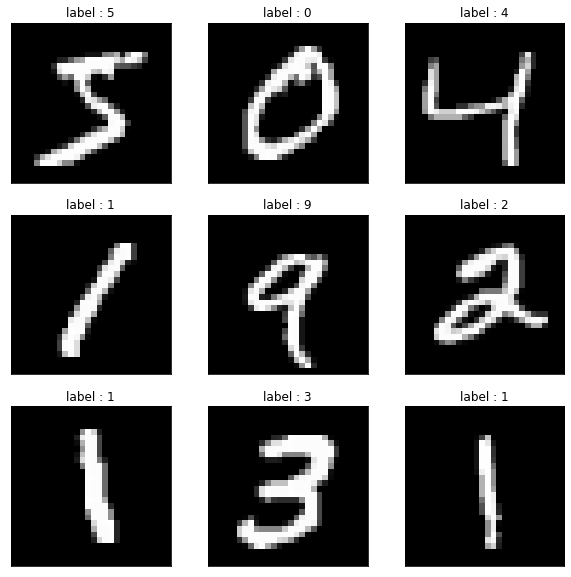

In [71]:
fig, ax = plt.subplots(3,3,figsize=(10,10))


for i,j in itertools.product(range(3),range(3)):
    index = 3*i + j
    image = np.reshape(X_train[index],(28,28))
    title = f"label : {np.argmax(Y_train[index])}"
    ax[i, j].imshow(image,cmap="gray")
    ax[i, j].set_title(title)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    

plt.show()

### 3.4 Add validation set

We are going to spare a small portion from our training data to use as validation set. We use this to set to prevent overfitting to the test set by testing different hyperparameters on it. Once we are satisfied with the results on the validation set,  we can move to the testing set to get a non-biased feedback on our model's performance.

In [72]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

### 3.5 Data augmentation

On each training epoch, we are going to perform some random modification to the images:

- Rotations between 0 and 15 degrees
- Height and width shifts between 0 and 20 %
- Zoom betwwen 0 and 20 %

This helps the model generalize well and helps prevent overfitting.

In [73]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)

gen.fit(X_train)

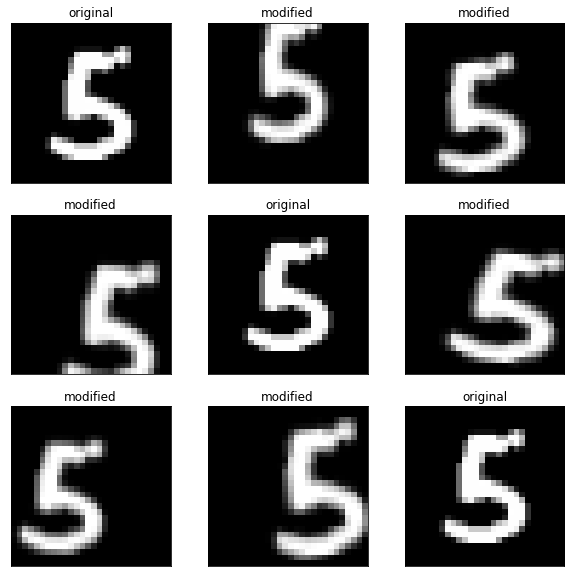

In [74]:
index = 5

original = X_train[index].reshape(1,28,28,1)

modified = gen.flow(original)

fig, ax = plt.subplots(3,3,figsize=(10,10))

for i,j in itertools.product(range(3),range(3)):
    if i == j:
        image = original.reshape(28,28)
        title = "original"
    else:
        image = next(modified).reshape(28,28)
        title = "modified"
        
    index = 3*i + j
    ax[i, j].imshow(image,cmap="gray");
    ax[i, j].set_title(title)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

# 4. Build the model

### 4.1 Model architecture

This model's architecure and parameters were inspired from this [kaggle kernel](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist), with some small changes.

Make sure to check it for a detailed explanation.

In [75]:
model = Sequential()

model.add(Input(shape=(28,28,1)))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(256, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(10, activation="softmax"))

### 4.2 Callback functions

These functions are going to be called during the training process. The first function reduces the learning rate when the model starts to plateau (the value accuracy is not improving). The second function creates a checkpoint of the best model so far, this way we make sure to have the best parameters at the end of the training.

In [76]:
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.7, patience=3, verbose=1, min_lr=0.00001)

checkpoint = ModelCheckpoint(monitor="val_accuracy", filepath="app/model", save_best_only=True)

### 4.3 loss function and optimizer

In [77]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 5. Train the model

In [78]:
history = model.fit(gen.flow(X_train, Y_train, batch_size=64), validation_data=(X_val, Y_val), epochs=50, callbacks=[checkpoint, reduce_lr])

Epoch 1/50
844/844 [==============================] - 22s 26ms/step - loss: 0.5746 - accuracy: 0.8247 - val_loss: 0.0785 - val_accuracy: 0.9767
Epoch 2/50
844/844 [==============================] - 22s 27ms/step - loss: 0.1699 - accuracy: 0.9478 - val_loss: 0.0808 - val_accuracy: 0.9795
Epoch 3/50
844/844 [==============================] - 22s 26ms/step - loss: 0.1264 - accuracy: 0.9629 - val_loss: 0.0649 - val_accuracy: 0.9800
Epoch 4/50
844/844 [==============================] - 22s 26ms/step - loss: 0.1061 - accuracy: 0.9681 - val_loss: 0.0576 - val_accuracy: 0.9835
Epoch 5/50
844/844 [==============================] - 22s 26ms/step - loss: 0.0920 - accuracy: 0.9722 - val_loss: 0.0421 - val_accuracy: 0.9858
Epoch 6/50
844/844 [==============================] - 22s 26ms/step - loss: 0.0816 - accuracy: 0.9757 - val_loss: 0.0357 - val_accuracy: 0.9905
Epoch 7/50
844/844 [==============================] - 18s 21ms/step - loss: 0.0775 - accuracy: 0.9775 - val_loss: 0.0369 - val_accuracy:

844/844 [==============================] - 18s 21ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0148 - val_accuracy: 0.9957
Epoch 50/50
842/844 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9953
Epoch 00050: ReduceLROnPlateau reducing learning rate to 5.76480058953166e-05.
844/844 [==============================] - 18s 21ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.0150 - val_accuracy: 0.9955


 # 6. Evaluate the model

### 6.1 Plot loss and accuracy curves

Let's visualize the loss function and accuracy of the model for both the training and validation sets.

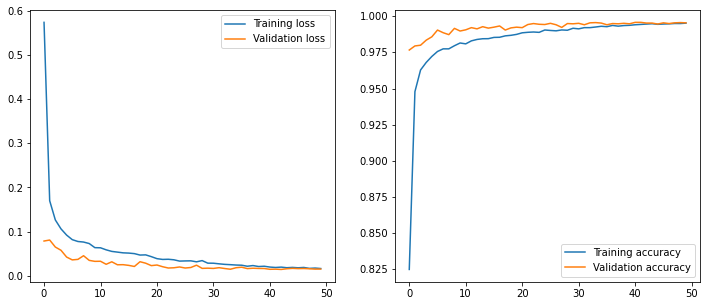

In [79]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(history.history["loss"], label="Training loss")
ax[0].plot(history.history["val_loss"], label="Validation loss")
ax[0].legend()


ax[1].plot(history.history["accuracy"], label="Training accuracy")
ax[1].plot(history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()

plt.show()

Now let's make sure to use the best model

In [80]:
best_model = load_model("model")

### 6.2 Visualize the model failures

Let's have a look at images wrongly classified by the model.

In [81]:
def get_wrong_labels(Y_pred, Y_val):
    for i  in range(len(Y_pred)):
        if np.argmax(Y_pred[i]) != np.argmax(Y_val[i]):
            yield i

Y_pred = best_model.predict(X_val)

gen = get_wrong_labels(Y_pred, Y_val)

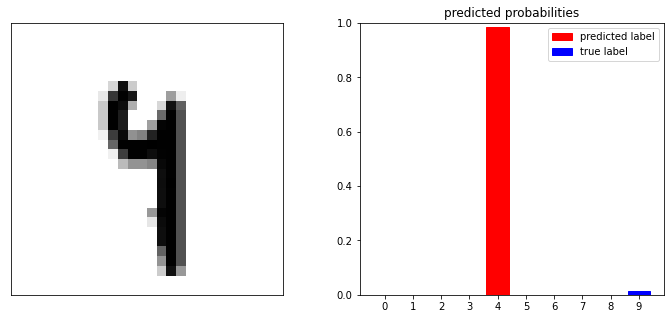

In [82]:
index = next(gen)


fig, ax = plt.subplots(1,2,figsize=(12,5))

image = np.reshape(X_val[index],(28,28))
true_label = np.argmax(Y_val[index])
predicted_label = np.argmax(Y_pred[index])
ax[0].imshow(image, cmap='binary')
ax[0].set_xticks([])
ax[0].set_yticks([])

bar = ax[1].bar(range(10), Y_pred[index],color='#777777')
bar[true_label].set_color('blue')
bar[true_label].set_label('true label')
bar[predicted_label].set_color('red')
bar[predicted_label].set_label('predicted label')
ax[1].set_xticks(range(10))
ax[1].set_title("predicted probabilities")
ax[1].set_ylim([0,1])
plt.legend()
plt.show()

As you can see above, most of the image the model predicted wrong are not trivial. It turns out that a human would have a hard time classifing this images. So the models's performance is pretty close to human-level performance.

### 6.3 Evaluate the model on the training set

Finally let's evaluate our model on the training set, just so we are sure our model is be doing good.

In [83]:
loss, accuracy = best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0098 - accuracy: 0.9965
